# Was beeinflusst die Skip Rate eines Songs?

Das gezielte Überspringen von Songs ist ein alltäglicher Bestandteil der Nutzung von Musikstreaming-Plattformen. Dabei wird ein Song manuell weitergeklickt, bevor er vollständig abgespielt wurde. Die sogenannte Skip Rate beschreibt den Anteil der Nutzer*innen, die einen bestimmten Song überspringen.

Ziel unserer Untersuchung ist es, besser zu verstehen, welche Merkmale mit der Skip Rate eines Songs in Verbindung stehen. Dazu gehören beispielsweise das Genre, die Popularität des Künstlers oder der Künstlerin, die Plattformnutzung (z. B. Free oder Premium), das Erscheinungsjahr oder die durchschnittliche Hördauer.

Als Datengrundlage nutzen wir einen Datensatz mit globalen Streamingzahlen aus dem Jahr 2024, bereitgestellt über die Plattform Kaggle. Der Datensatz enthält unter anderem Informationen zu Künstler*innen, Songs, Genres, Plattformtyp, Streams, Hörer*innenzahlen und Skip Rate.

Ziel ist es nicht nur, bestimmte Einflüsse zu identifizieren, sondern auch kritisch zu reflektieren, welche Merkmale im gegebenen Datensatz möglicherweise keine Rolle spielen – und warum.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = "data/spotify.csv"
try:
    df = pd.read_csv(data_path)
except:
    # Achtung der Pfad "../../../_Daten" muss existieren.
    import kagglehub
    import shutil
    # Download latest version
    path = kagglehub.dataset_download("atharvasoundankar/spotify-global-streaming-data-2024")
    
    # Get the first file in path
    files = os.listdir(path)
    if len(files) == 0:
        raise ValueError("No files found in the downloaded dataset.")
    # Check if the data directory exists, if not create it
    if not os.path.exists("data"):
        os.makedirs("data")

    # Move the downloaded file to the desired directory
    shutil.move(os.path.join(path, files[0]), data_path)

    print("Spotifiy dataset downloaded successfully!")

# 1. Explorative Datenanalyse – Einflussfaktoren auf die Skip Rate

Ziel dieses Abschnitts ist es, einen ersten Überblick über die Struktur und Inhalte des Datensatzes zu gewinnen.
Die explorative Datenanalyse (EDA) hilft dabei, Auffälligkeiten, Verteilungen, Ausreißer und potenzielle Einflussfaktoren auf die Skip Rate zu erkennen.

Die EDA dient außerdem als Grundlage für weitere Analysen, etwa die Hauptkomponentenanalyse (PCA) und eine spätere Modellbildung.
Auch wenn sie typischerweise vor der PCA durchgeführt wird, wird sie hier nachträglich eingefügt, da die Arbeit arbeitsteilig erfolgt ist.

## 1.1 Überblick über den Datensatz

Im Folgenden wird ein erster Blick auf den Datensatz geworfen. Dabei interessieren uns insbesondere:
- die verfügbaren Spalten,
- der generelle Aufbau der Daten (z. B. Anzahl der Zeilen, Datentypen),
- sowie ein erster Eindruck der enthaltenen Informationen.

Diese erste Sichtung hilft dabei, ein Gefühl dafür zu bekommen, welche Merkmale später für die Analyse der Skip Rate von Bedeutung sein könnten.


In [3]:
# Überblick über Struktur und Datentypen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          500 non-null    object 
 1   Artist                           500 non-null    object 
 2   Album                            500 non-null    object 
 3   Genre                            500 non-null    object 
 4   Release Year                     500 non-null    int64  
 5   Monthly Listeners (Millions)     500 non-null    float64
 6   Total Streams (Millions)         500 non-null    float64
 7   Total Hours Streamed (Millions)  500 non-null    float64
 8   Avg Stream Duration (Min)        500 non-null    float64
 9   Platform Type                    500 non-null    object 
 10  Streams Last 30 Days (Millions)  500 non-null    float64
 11  Skip Rate (%)                    500 non-null    float64
dtypes: float64(6), int64(1

In [4]:
# Vorschau auf die ersten Zeilen im Datensatz
df.head()

,Country,Artist,Album,Genre,Release Year,Monthly Listeners (Millions),Total Streams (Millions),Total Hours Streamed (Millions),Avg Stream Duration (Min),Platform Type,Streams Last 30 Days (Millions),Skip Rate (%)
0,Germany,Taylor Swift,1989 (Taylor's Version),K-pop,2020,23.10,3695.53,14240.35,4.28,Free,118.51,2.24
1,Brazil,The Weeknd,After Hours,R&B,2023,60.60,2828.16,11120.44,3.90,Premium,44.87,23.98
2,United States,Post Malone,Austin,Reggaeton,2019,42.84,1425.46,4177.49,4.03,Free,19.46,4.77
3,Italy,Ed Sheeran,Autumn Variations,K-pop,2019,73.24,2704.33,12024.08,3.26,Premium,166.05,25.12
4,Italy,Ed Sheeran,Autumn Variations,R&B,2019,7.89,3323.25,13446.32,4.47,Free,173.43,15.82


In [5]:
# Alle Spaltennamen anzeigen
df.columns.tolist()

['Country',
 'Artist',
 'Album',
 'Genre',
 'Release Year',
 'Monthly Listeners (Millions)',
 'Total Streams (Millions)',
 'Total Hours Streamed (Millions)',
 'Avg Stream Duration (Min)',
 'Platform Type',
 'Streams Last 30 Days (Millions)',
 'Skip Rate (%)']

## 1.2 Deskriptive Analyse der Zielgröße: Skip Rate (%)

Zunächst betrachten wir die Verteilung der Zielvariablen `Skip Rate (%)`. Ziel ist es, ein Gefühl für typische Werte, Ausreißer und die Streuung zu bekommen.

count    500.000000
mean      20.370460
std       10.597202
min        1.160000
5%         3.667500
25%       11.152500
50%       20.820000
75%       28.760000
95%       37.162500
max       39.970000
Name: Skip Rate (%), dtype: float64


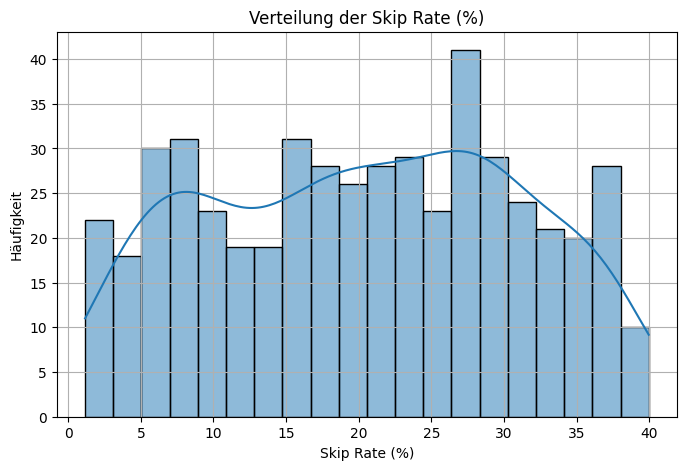

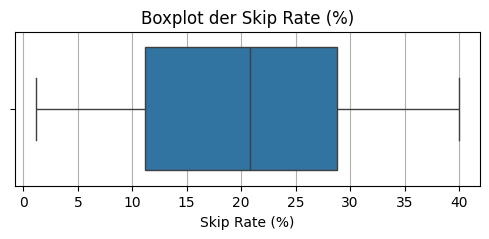

In [6]:
# Deskriptive Statistik
skip_stats = df["Skip Rate (%)"].describe(percentiles=[.05, .25, .5, .75, .95])
print(skip_stats)

# Histogramm
plt.figure(figsize=(8, 5))
sns.histplot(df["Skip Rate (%)"], bins=20, kde=True)
plt.title("Verteilung der Skip Rate (%)")
plt.xlabel("Skip Rate (%)")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 2))
sns.boxplot(x=df["Skip Rate (%)"])
plt.title("Boxplot der Skip Rate (%)")
plt.xlabel("Skip Rate (%)")
plt.grid(True, axis='x')
plt.show()

### Beobachtungen zur Verteilung der Skip Rate

Die Skip Rate in diesem Datensatz liegt im Durchschnitt bei etwa 20 %, wobei die meisten Songs Werte zwischen 10 % und 30 % aufweisen.
Einige Songs stechen jedoch mit sehr niedriger oder sehr hoher Skip Rate hervor. So liegt das untere 5. Perzentil bei lediglich 3.7 %, das obere 5. Perzentil hingegen bei über 37 %.

Insgesamt zeigt sich eine relativ gleichmäßige Verteilung ohne starke Schieflage, was darauf hinweist, dass das Überspringverhalten nicht durch eine einzelne Gruppe dominiert wird.
Die Werte deuten darauf hin, dass sowohl besonders „skip-resistente“ als auch „skip-anfällige“ Songs existieren, die in weiteren Analysen gezielt betrachtet werden könnten.

## 1.3 Skip Rate nach Musikgenre

Da Musikgeschmack stark genreabhängig ist, könnte auch die Skip Rate mit dem Genre eines Songs zusammenhängen.
Unterschiedliche Genres sprechen unterschiedliche Zielgruppen an und können sich hinsichtlich Aufbau, Länge und Hörgewohnheiten stark unterscheiden.

Im Folgenden wird untersucht, wie hoch die durchschnittliche Skip Rate je Genre ausfällt.

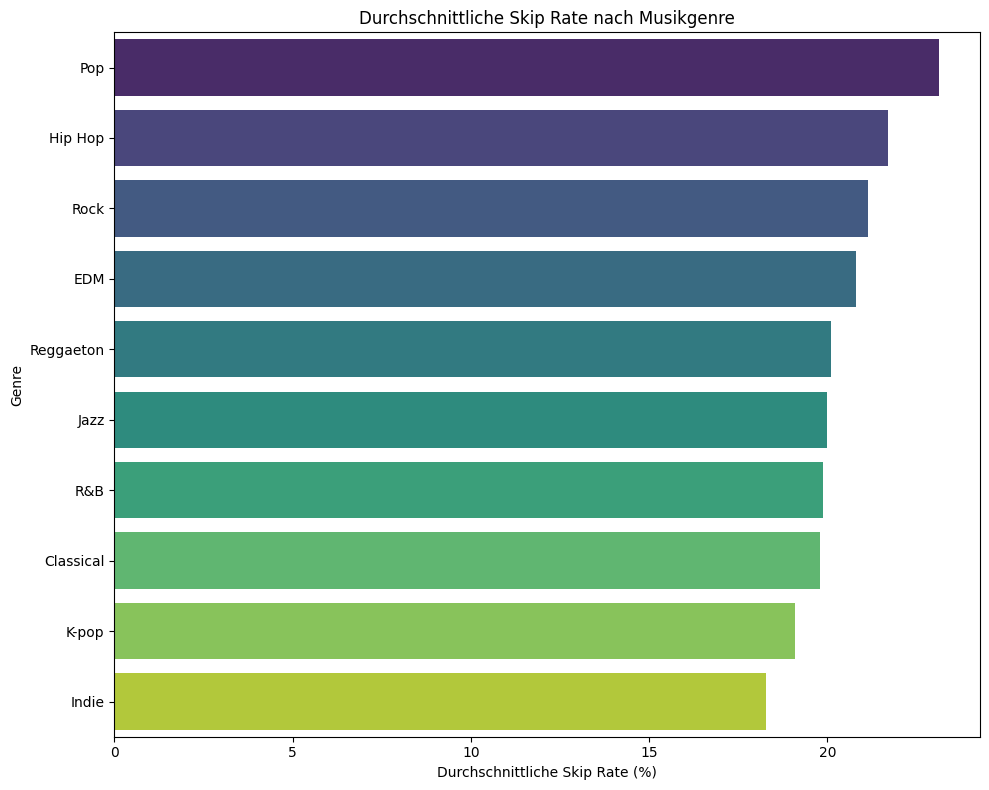

In [7]:
# Durchschnittliche Skip Rate pro Genre berechnen
genre_means = df.groupby("Genre")["Skip Rate (%)"].mean().sort_values(ascending=False)

# Plot erstellen
plt.figure(figsize=(10, 8))
sns.barplot(
    x=genre_means.values,
    y=genre_means.index,
    hue=genre_means.index,
    palette="viridis",
    dodge=False,
    legend=False
)
plt.xlabel("Durchschnittliche Skip Rate (%)")
plt.ylabel("Genre")
plt.title("Durchschnittliche Skip Rate nach Musikgenre")
plt.tight_layout()
plt.show()

### Analyse: Durchschnittliche Skip Rate nach Genre

Die Analyse zeigt klare Unterschiede in der durchschnittlichen Skip Rate je Musikgenre.
Besonders auffällig ist, dass Pop-Songs am häufigsten übersprungen werden, gefolgt von Hip Hop, Rock und EDM.
Genres wie Indie, K-pop und klassische Musik weisen dagegen die niedrigsten Skip Rates im Datensatz auf.

Ein möglicher Erklärungsansatz ist, dass populäre Genres wie Pop häufiger konsumiert werden und damit einem stärkeren Bewertungskontext unterliegen. Nutzer*innen skippen eher, wenn ihnen der Song nicht sofort gefällt.
Weniger massentaugliche Genres wie Indie oder Classical könnten dagegen gezielter ausgewählt und daher seltener übersprungen werden.

Diese Beobachtungen legen nahe, dass das Genre tatsächlich ein relevanter Prädiktor für die Skip Rate sein könnte und in weiteren Analysen berücksichtigt werden sollte.

## 1.4 Streuung der Skip Rate innerhalb der Genres

Nachdem wir bereits die durchschnittliche Skip Rate je Genre betrachtet haben, analysieren wir nun die Verteilung innerhalb der einzelnen Genres.
Boxplots zeigen dabei sowohl typische Werte (Median), als auch die Streuung (Interquartilsabstand) und eventuelle Ausreißer.

Das hilft einzuschätzen, ob bestimmte Genres besonders stabil (gleichbleibendes Skip-Verhalten) oder besonders uneinheitlich sind.

C:\Users\Jan\AppData\Local\Temp\ipykernel_17188\1730351496.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Skip Rate (%)", y="Genre", palette="viridis")


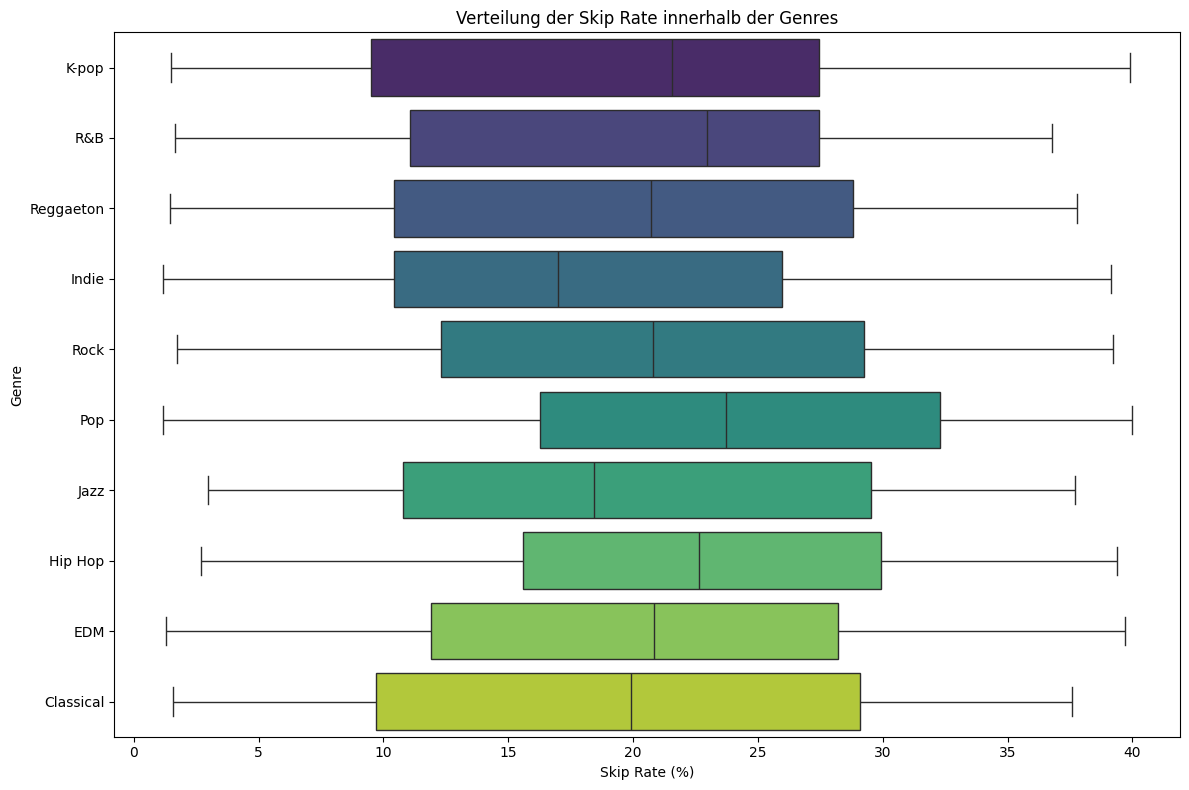

In [8]:
# Boxplot der Skip Rate pro Genre
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x="Skip Rate (%)", y="Genre", palette="viridis")
plt.title("Verteilung der Skip Rate innerhalb der Genres")
plt.xlabel("Skip Rate (%)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

### Interpretation: Skip Rate – Streuung innerhalb der Genres

Die Boxplots zeigen, dass die Skip Rate innerhalb der meisten Genres stark variiert.
Für nahezu alle Genres finden sich sowohl Songs mit extrem niedriger als auch sehr hoher Skip Rate. Das legt nahe, dass das Genre zwar ein relevanter Faktor für die Skip Rate im Mittel ist, aber nicht allein entscheidend.

Einige Genres wie K-pop und R&B wirken vergleichsweise konsistent, während andere wie Jazz und Classical extrem breit verteilt sind.
Hier könnte sich lohnen, zusätzlich andere Einflussfaktoren wie Popularität oder Stream-Dauer einzubeziehen, um diese Unterschiede besser zu erklären.

## 1.5 Zusammenhang zwischen Skip Rate und monatlicher Hörerzahl

Ein möglicher Einflussfaktor auf die Skip Rate ist die Popularität der Künstler*innen.
Es liegt nahe anzunehmen, dass Songs von sehr bekannten Künstler**innen mit vielen monatlichen Hörer*innen seltener übersprungen werden, z. B. weil sie bekannter oder erwarteter sind.

Im Folgenden wird dieser Zusammenhang mittels eines Scatterplots dargestellt.

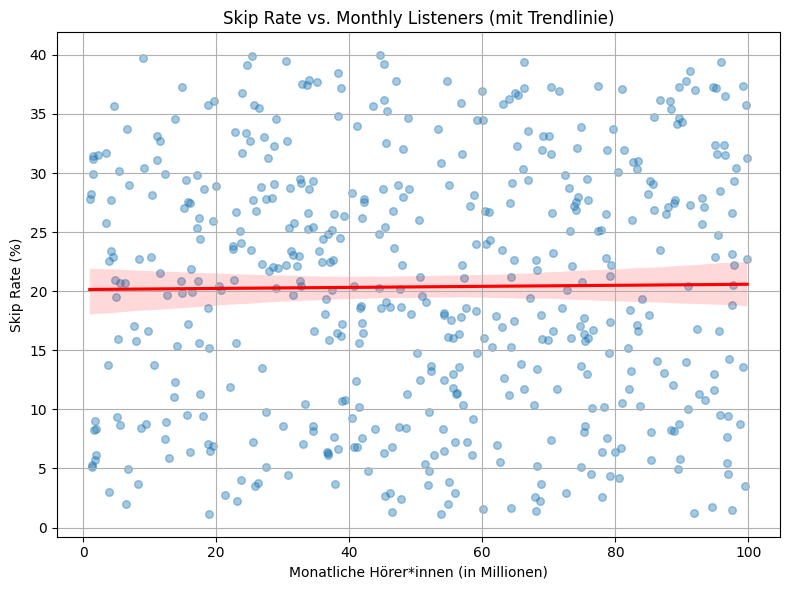

Korrelation zwischen Skip Rate und Monthly Listeners: 0.01


In [9]:
# Scatterplot: Skip Rate vs. Monthly Listeners
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df,
    x="Monthly Listeners (Millions)",
    y="Skip Rate (%)",
    scatter_kws={'alpha':0.4, 's':30},
    line_kws={'color': 'red'}
)
plt.title("Skip Rate vs. Monthly Listeners (mit Trendlinie)")
plt.xlabel("Monatliche Hörer*innen (in Millionen)")
plt.ylabel("Skip Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Korrelationskoeffizient berechnen
corr = df["Monthly Listeners (Millions)"].corr(df["Skip Rate (%)"])
print(f"Korrelation zwischen Skip Rate und Monthly Listeners: {corr:.2f}")

### Interpretation: Skip Rate und monatliche Hörer*innen

Die Analyse zeigt, dass es keinen erkennbaren Zusammenhang zwischen der Skip Rate eines Songs und der monatlichen Hörerzahl der Künstler*innen gibt.
Dies bestätigt auch der Korrelationswert von 0.01 – also praktisch null.

Daraus lässt sich schließen, dass die Popularität eines Künstlers kein verlässlicher Prädiktor dafür ist, wie häufig ein Song übersprungen wird.
Sowohl sehr beliebte als auch wenig bekannte Künstler*innen können Songs mit hoher oder niedriger Skip Rate haben.
Daher sollten für weitere Analysen andere Merkmale wie Genre, Plattform oder Streaming-Verhalten stärker in den Fokus rücken.

## 1.6 Skip Rate in Abhängigkeit vom Erscheinungsjahr

Ein weiterer potenzieller Einflussfaktor auf das Überspringverhalten könnte das Erscheinungsjahr eines Songs sein.
Es ist denkbar, dass Songs, die vor kurzem veröffentlicht wurden, entweder besonders oft gehört oder auch schneller wieder übersprungen werden, z. B. aufgrund von Trends oder Streaming-Routinen.

Im Folgenden wird untersucht, ob es systematische Unterschiede in der durchschnittlichen Skip Rate zwischen verschiedenen Release-Jahren gibt.

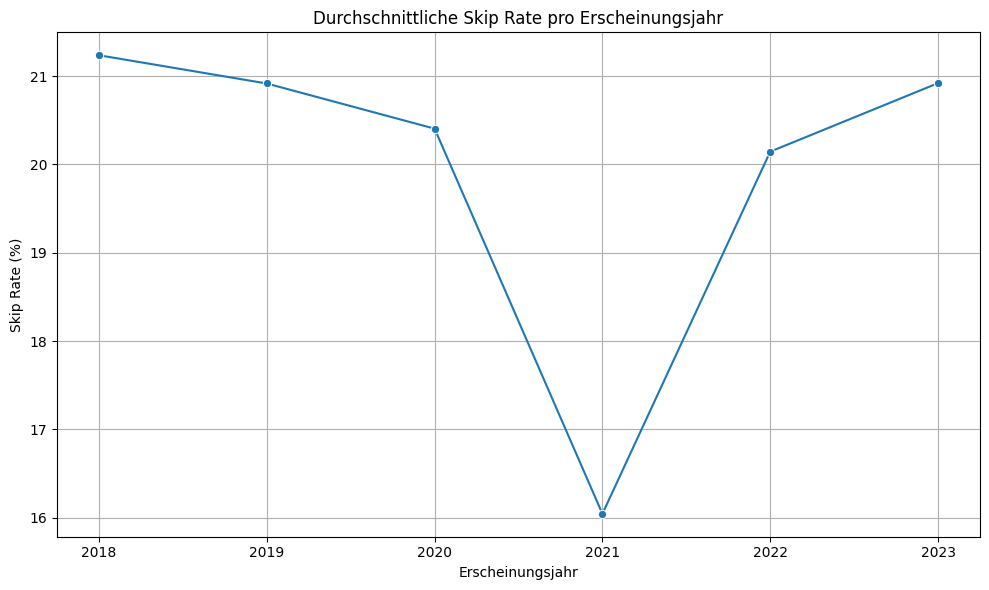

In [10]:
# Durchschnittliche Skip Rate pro Jahr
year_means = df.groupby("Release Year")["Skip Rate (%)"].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=year_means.index, y=year_means.values, marker="o")
plt.title("Durchschnittliche Skip Rate pro Erscheinungsjahr")
plt.xlabel("Erscheinungsjahr")
plt.ylabel("Skip Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation: Skip Rate im zeitlichen Verlauf

Zwischen 2018 und 2023 zeigt sich ein leichter, aber auffälliger Trend:
Die durchschnittliche Skip Rate sinkt zunächst bis zum Jahr 2021 deutlich ab, bevor sie in den Jahren 2022 und 2023 wieder leicht ansteigt.

Besonders auffällig ist das Jahr 2021, das mit einer durchschnittlichen Skip Rate von nur ca. 16 % einen deutlichen Ausreißer nach unten darstellt.
Mögliche Erklärungsansätze könnten hier externe Einflüsse sein – etwa Pandemie-bedingte Veränderungen im Hörverhalten oder algorithmische Anpassungen bei Streamingdiensten.

Insgesamt lässt sich jedoch kein klarer linearer Zusammenhang zwischen Erscheinungsjahr und Skip Rate feststellen.
Der Einfluss des Release-Jahres scheint eher moderat zu sein, sollte aber in Kombination mit anderen Merkmalen weiter untersucht werden.

## 1.7 Skip Rate nach Plattformtyp

Die Art der genutzten Plattform, etwa ob ein Nutzer oder eine Nutzerin ein kostenloses oder kostenpflichtiges Abo verwendet, kann das Hörverhalten beeinflussen.
Nutzer*innen von kostenlosen Versionen hören möglicherweise weniger aufmerksam oder sind stärker zu aktivem Überspringen geneigt (z. B. durch algorithmische Vorschläge oder Werbeunterbrechungen).

Im Folgenden wird die durchschnittliche Skip Rate nach Plattformtyp verglichen.

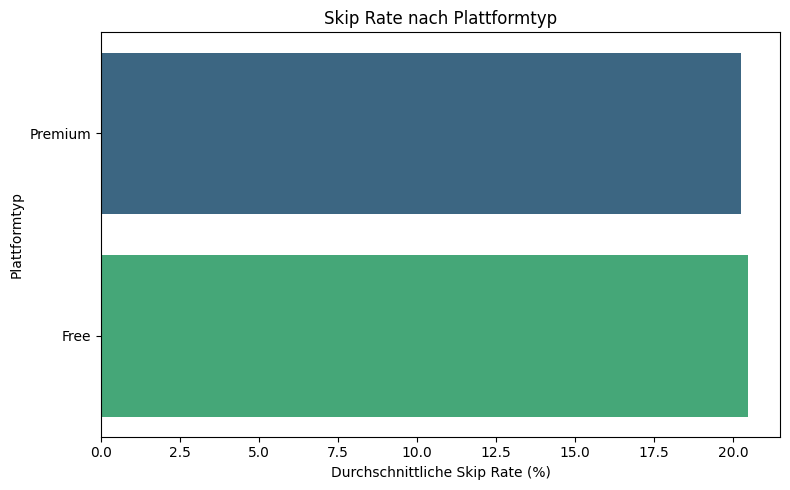

In [11]:
# Mittelwert der Skip Rate je Plattformtyp berechnen
platform_means = df.groupby("Platform Type")["Skip Rate (%)"].mean().sort_values()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=platform_means.values,
    y=platform_means.index,
    hue=platform_means.index,
    palette="viridis",
    dodge=False,
    legend=False
)
plt.xlabel("Durchschnittliche Skip Rate (%)")
plt.ylabel("Plattformtyp")
plt.title("Skip Rate nach Plattformtyp")
plt.tight_layout()
plt.show()

### Interpretation: Plattformtyp als Einflussfaktor

Die Analyse zeigt, dass der Plattformtyp keinen signifikanten Unterschied in der durchschnittlichen Skip Rate aufweist.
Beide Gruppen liegen mit einer durchschnittlichen Skip Rate von etwas über 20 % nahezu gleichauf.

Das Ergebnis widerlegt die Hypothese, dass Free-Nutzer*innen aufgrund möglicher Werbeunterbrechungen oder weniger gezielter Songauswahl häufiger Songs überspringen.
Stattdessen scheint das Überspringverhalten unabhängig vom Abo-Modell zu sein und wird wahrscheinlich stärker von anderen Faktoren wie Genre, Songstruktur oder Algorithmen beeinflusst.

## 1.8 Skip Rate in Abhängigkeit von der durchschnittlichen Stream-Dauer

Ein möglicher Einflussfaktor auf das Überspringverhalten ist die durchschnittliche Hördauer eines Songs.
Die Variable `Avg Stream Duration (Min)` zeigt, wie lange ein Song im Durchschnitt pro Stream gehört wird.

In der folgenden Analyse wird untersucht, ob eine Korrelation zwischen der durchschnittlichen Stream-Dauer und der Skip Rate besteht.

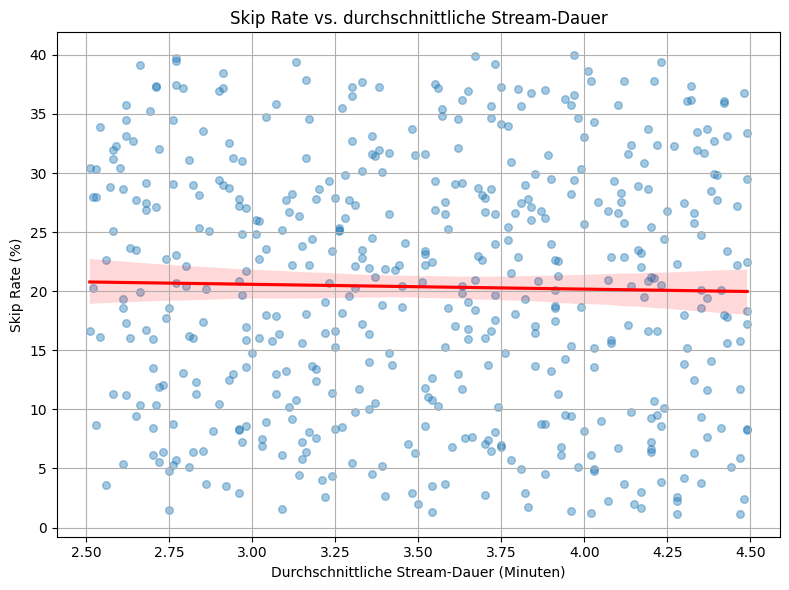

Korrelation zwischen Skip Rate und Stream-Dauer: -0.02


In [12]:
# Scatterplot: Skip Rate vs. durchschnittliche Hördauer
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df,
    x="Avg Stream Duration (Min)",
    y="Skip Rate (%)",
    scatter_kws={'alpha':0.4, 's':30},
    line_kws={'color': 'red'}
)
plt.title("Skip Rate vs. durchschnittliche Stream-Dauer")
plt.xlabel("Durchschnittliche Stream-Dauer (Minuten)")
plt.ylabel("Skip Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Korrelationskoeffizient berechnen
corr_duration = df["Avg Stream Duration (Min)"].corr(df["Skip Rate (%)"])
print(f"Korrelation zwischen Skip Rate und Stream-Dauer: {corr_duration:.2f}")

### Interpretation: Einfluss der durchschnittlichen Stream-Dauer auf die Skip Rate

Die Analyse zeigt, dass zwischen der durchschnittlichen Hördauer eines Songs und dessen Skip Rate kein nennenswerter Zusammenhang besteht.
Der Korrelationswert von –0.02 bestätigt, dass sich die beiden Variablen praktisch unabhängig voneinander verhalten.

Das widerspricht eventuell der intuitiven Annahme, dass kürzer gestreamte Songs auch häufiger übersprungen werden.
Tatsächlich scheint die Länge eines durchschnittlichen Streams nicht aussagekräftig dafür zu sein, wie häufig ein Song geskippt wird.

## 1.9 Fazit der explorativen Datenanalyse

Im Rahmen dieser explorativen Datenanalyse wurde untersucht, welche Faktoren potenziell mit der Skip Rate von Songs auf Streaming-Plattformen zusammenhängen.
Ziel war es, auf Basis des Datensatzes "Spotify Global Streaming Data 2024" Hypothesen zu formulieren und erste Zusammenhänge sichtbar zu machen.

Die wichtigsten Erkenntnisse im Überblick:

- **Genre**: Der deutlichste Einflussfaktor. Es zeigten sich klare Unterschiede in der durchschnittlichen Skip Rate zwischen verschiedenen Musikrichtungen. Pop-Songs wiesen die höchste durchschnittliche Skip Rate auf, während z. B. Indie, K-pop und klassische Musik eher seltener übersprungen wurden. Auch die Streuung innerhalb der Genres war teils sehr unterschiedlich.

- **Plattformtyp (Free vs. Premium)**: Es konnte kein relevanter Unterschied in der durchschnittlichen Skip Rate festgestellt werden. Das Überspringverhalten scheint unabhängig vom Abo-Modell zu sein.

- **Beliebtheit (Monthly Listeners)**: Der Korrelationswert von nur 0.01 deutet auf keinen Zusammenhang zwischen der Popularität eines Künstlers und der Skip Rate seiner Songs hin.

- **Erscheinungsjahr**: Ein leichter Trend mit einem auffälligen Rückgang der Skip Rate im Jahr 2021 war erkennbar, jedoch ohne klaren linearen Zusammenhang. Aufgrund der begrenzten Jahrgangsbreite im Datensatz ist diese Analyse nur eingeschränkt aussagekräftig.

- **Durchschnittliche Stream-Dauer**: Auch hier zeigte sich kein relevanter Zusammenhang. Die Skip Rate war weitgehend unabhängig davon, wie lange ein Song im Schnitt pro Stream gehört wurde.

### Zusammenfassung:

Die explorative Datenanalyse zeigt, dass insbesondere das Genre eines Songs ein zentraler Prädiktor für das Überspringverhalten sein kann. Andere Merkmale wie Beliebtheit, Plattform oder Hördauer haben dagegen keinen erkennbaren Einfluss im gegebenen Datensatz.

# 3.1 Hauptkomponenten Analyse
Die Hauptkomponentenanalyse (PCA) ist ein Verfahren zur Dimensionsreduktion, das darauf abzielt, die wesentlichen Strukturen in hochdimensionalen Datensätzen zu erkennen. Sie transformiert die ursprünglichen Variablen in eine neue Menge unkorrelierter Variablen, die sogenannten Hauptkomponenten. Diese Hauptkomponenten sind so konstruiert, dass die erste Komponente die größte mögliche Varianz der Daten erklärt, die zweite die nächstgrößte und so weiter. Die Transformation erfolgt durch eine lineare Kombination der Ausgangsvariablen, wobei die Gewichte (Ladungen) die Bedeutung der einzelnen Variablen für die jeweilige Komponente angeben. 

PCA ermöglicht es, Muster und Zusammenhänge in den Daten zu erkennen, die mit bloßem Auge schwer zu identifizieren wären. Die Interpretation der Hauptkomponenten erfolgt über die Ladungen: Hohe positive oder negative Werte zeigen, welche Variablen besonders stark zur jeweiligen Komponente beitragen. Durch die Reduktion auf wenige Hauptkomponenten kann man die Komplexität der Daten verringern und gleichzeitig einen Großteil der Information bewahren.

Zunächst werden die kategorialen Variablen des Datensatzes mit einem One-Hot-Encoding umgeformt.

In [13]:
# Teilung der Test Daten zur Vorhersage der Skip Rate (%) mit Kodierung kategorialer Variablen
# Kategoriale Variablen werden automatisch per One-Hot-Encoding kodiert.
# Feature- und Zielspalten
feature_cols = [
    'Country', 
    'Artist', 
    'Album', 
    'Genre', 
    'Release Year',
    'Monthly Listeners (Millions)', 
    'Total Streams (Millions)',
    'Total Hours Streamed (Millions)', 
    'Avg Stream Duration (Min)',
    'Streams Last 30 Days (Millions)'
]

target_col = 'Skip Rate (%)'

# Filtere und bereite die Daten vor
df_reg = df[feature_cols + [target_col]].dropna()
X = df_reg[feature_cols]
y = df_reg[target_col]

# Kategoriale Variablen kodieren mit One-Hot-Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

Bevor eine Hauptkomponentenanalyse durchgeführt wird, werden alle Variablen Standertisiert um Vergleichbarkeit zwischen den Variablen herzustellen.

In [14]:
# Hauptkomponentenanalyse (PCA) auf den kodierten Features
# Die Features werden vor der PCA standardisiert.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


Zur Selektion der Hauptkomponenten suchen wir zunächst, wie viele Komponenten es brauch um 90% der Varianz der Daten zu erklären. 
Die gefundenen Komponenten stellen wir nun mit ihrem Eigenwert in einem Scree-Plot dar. An diesem kann ein signifikanter Sprung identifiziert werden, um zu Entscheiden ab welchen Komponentenanzahl der Cutoff gewählt wird.
Visuell auffällig sind die Sprunge zur Zweiten, Zwölften und Dreizehnten Komponente. Alle Komponente zwischen von dem Ersten bis zur 13. haben einen Eigenwert größer als eins und genügen damit dem Kaiser-Kriterium. 
Da eine weitere Analyse mit nur einem Kriterium reduntant wäre, wird sich für den nächsten signifikanten Knick an der Komponente zwölf entschieden. 

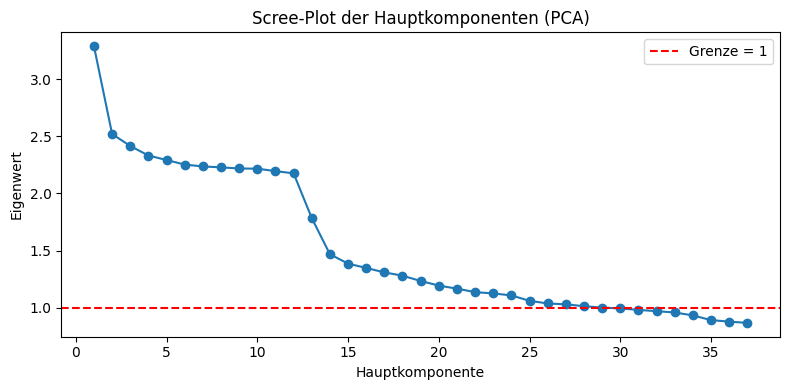

In [15]:
# Führe PCA durch, sodass mindestens 90% der Varianz erklärt werden
pca = PCA(n_components=0.9, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

# Scree-Plot: Eigenwerte der Hauptkomponenten
plt.figure(figsize=(8,4))
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.axhline(1, color='red', linestyle='--', label='Grenze = 1')
plt.xlabel('Hauptkomponente')
plt.ylabel('Eigenwert')
plt.title('Scree-Plot der Hauptkomponenten (PCA)')
plt.legend()
plt.tight_layout()
plt.show()


Die zwölf selektieren Komponeten erkären gemeinsam 45,66% der Varianz der Daten 

In [16]:
pca = PCA(n_components=12, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

print(f"Erklärte Varianz: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")


Erklärte Varianz: 45.66%


Nun stellen wir die Ladungen der Variablen auf den Komponenten dar. Dazu wird eine Varimax transformation genutzt um starke Ladungen hervorzuheben und schwache Ladungen zu unterdrücken. 
An der Resultierenden Übersicht ist auffällig das jede Komponente von einem Album und ihrem jeweilgen Künstler*innen dominiert wird. 
Die allgemeinerien Variablen, wie das Erscheinungsjahr oder die Monatlichen Höhrer laden tendenziel auf alle Komponenten gleichermaßen. 
An der Darstellung ist zu beachten, dass alle Werte die unter den Wert von 0,2 fallen ausgeblendet wurden und die Tabelle lesbar zu gestalten. 

In [17]:
# Rotierte Komponentenmatrix (Varimax-Rotation)
from factor_analyzer.rotator import Rotator

# Varimax-Rotation auf die PCA-Komponentenmatrix anwenden
rotator = Rotator(method='varimax')
rotated_components = rotator.fit_transform(pca.components_.T).T

# Rotierte Komponentenmatrix als DataFrame anzeigen
rotated_df = pd.DataFrame(rotated_components, columns=X_encoded.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)]).T

# Für jede Variable: Komponente mit höchster Ladung (nach Betrag) bestimmen
max_comp = rotated_df.abs().idxmax(axis=1)
max_val = rotated_df.abs().max(axis=1)
comp_num = max_comp.str.extract(r'(\d+)').astype(int)[0]

# Sortierindex erstellen: erst nach Komponente, dann nach Höhe der Ladung (absteigend)
sort_idx = pd.DataFrame({'comp': comp_num, 'val': max_val})
sort_idx = sort_idx.sort_values(['comp', 'val'], ascending=[True, False]).index
rotated_df_sorted = rotated_df.loc[sort_idx]

# Werte < 0.08 ausblenden
rotated_df_masked = rotated_df_sorted.map(lambda x: x if abs(x) >= 0.2 else "")

# Trick um das gesamte DataFrame anzuzeigen
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(rotated_df_masked)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Artist_Dua Lipa,0.5867,,,,,,,,,,,
Album_Future Nostalgia,0.5867,,,,,,,,,,,
Country_South Korea,,,,,,,,,,,,
Streams Last 30 Days (Millions),,,,,,,,,,,,
Genre_Rock,,,,,,,,,,,,
Artist_SZA,,-0.560311,,,,,,,,,,
Album_SOS,,-0.560311,,,,,,,,,,
Total Hours Streamed (Millions),,0.344257,,,,,,,,,,
Total Streams (Millions),,0.329339,,,,,,,,,,
Country_France,,,,,,,,,,,,


# 3.2 Entscheidungsbaum
Als Alternative Methode zur multiplen linearen Regression, welche die Skip Rate beeinflusst, wird ein Regressionsentscheidungsbaum trainiert.
Ein Regressionsentscheidungsbaum ist ein Modell aus dem Bereich des maschinellen Lernens, das zur Vorhersage kontinuierlicher Zielgrößen eingesetzt wird. Der Baum besteht aus Knoten, an denen die Daten anhand von Entscheidungsregeln (z.B. Schwellenwerten einzelner Variablen) in Teilmengen aufgeteilt werden. Jeder Endknoten (Blatt) des Baums gibt eine Vorhersage für die Zielgröße ab, typischerweise den Mittelwert der Zielwerte in diesem Blatt. Die Aufteilung erfolgt so, dass die Homogenität innerhalb der Blätter maximiert wird, d.h. die Varianz der Zielgröße innerhalb eines Blatts möglichst gering ist.

Entscheidungsbäume sind leicht interpretierbar, da sie explizite Entscheidungsregeln liefern, die nachvollziehbar sind. Sie ermöglichen es, die wichtigsten Einflussvariablen auf die Zielgröße zu identifizieren, indem man die Struktur des Baums und die verwendeten Splits analysiert. Allerdings neigen Entscheidungsbäume dazu, auf kleine Datensätze zu überfitten, weshalb oft Methoden wie Kreuzvalidierung oder Ensemble-Methoden (z.B. Random Forests) eingesetzt werden, um die Generalisierbarkeit zu verbessern. Die Interpretation eines Entscheidungsbaums erfolgt über die Analyse der Splits und der Feature-Importances, die angeben, welche Variablen am häufigsten und mit dem größten Einfluss für die Aufteilung der Daten verwendet wurden.

Hierzu teilen wir den Datensatz in 20% Testdaten und 80% Trainingsdaten.

In [18]:
# Splitte die Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

Da die optimalen Parameter für das Training eines Entscheidungsbaums mit den gegeben Daten unbekannt ist, wird mit einer Gridsuche systematisch Parameter ausprobiert. Es werden jene Parameter ausgewählt, welche in dem größten Wert des Bestimmtheitsmaßes, R², resultieren.

In [19]:
# Grid Search zur Optimierung der Entscheidungsbaum-Parameter
param_grid = {
    'max_depth': [4, 6, 8, 12, None],
    'min_impurity_decrease': [0.0, 0.01, 0.1, 0.5],
    'min_samples_split': [2, 5, 10, 20]
}

grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Beste Parameterkombination:")
print(grid_search.best_params_)
print(f"Bester mittlerer R²-Score: {grid_search.best_score_:.3f}")

# Optional: Ergebnisse als DataFrame anzeigen
# results_df = pd.DataFrame(grid_search.cv_results_)
# display(results_df[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head(10))

Beste Parameterkombination:
{'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_split': 20}
Bester mittlerer R²-Score: -0.250


Mit den nun bestimmten Parametern wird ein Modell trainiert, welches für weitere Berechnungen verwendet wird.

In [20]:

# Trainiere den Regressionsbaum
reg_tree = DecisionTreeRegressor(**grid_search.best_params_, random_state=42)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_split=20, random_state=42)

Um ein Overfitting des Modells zu kontrollieren wird eine Kreuzvalidierung über 5 Holdouts berechnet. Das Ergebnis weißt eine akzeptierbare Streuung auf in an betracht der geringen Datenmenge.

In [21]:
# Cross-Validierung für den Regressionsentscheidungsbaum
splits = 5
cv = KFold(n_splits=splits, shuffle=True, random_state=42)

# R²-Scores
r2_scores = cross_val_score(reg_tree, X_encoded, y, cv=cv, scoring='r2')
print(f"Mittlerer R²-Score ({splits}-fold CV): {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")

# MSE-Scores (negativ, daher Vorzeichen umdrehen)
mse_scores = cross_val_score(reg_tree, X_encoded, y, cv=cv, scoring=make_scorer(mean_squared_error, greater_is_better=False))
print(f"Mittlerer MSE ({splits}-fold CV): {(-np.mean(mse_scores)):.3f} ± {np.std(mse_scores):.3f}")

Mittlerer R²-Score (5-fold CV): -0.141 ± 0.073
Mittlerer MSE (5-fold CV): 126.430 ± 7.767
Mittlerer MSE (5-fold CV): 126.430 ± 7.767


Final wird ein Regressionsbaum trainiert dessen Bestimmtheitsmaß negativ ist. Dies lässt darauf schließen, dass die Model schlechter auf die Daten passt als eine vaagerechte Line. Abschließend ist daher zu folgern, dass eine Vorhersage der Skip Rate mittels eines Regressionentscheidungsbaum nicht möglich ist. 

In [22]:
# Vorhersage und Bewertung
y_pred = reg_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.3f}, R²: {r2:.3f}")


MSE: 123.624, R²: -0.076


# Anhang
Im Folgeden sind die Darstellungen der Wichtigkeiten der Variablen innerhalb des Entscheidungsbaums dargestellt. Zu erst werden die Wichtigkeit aller Variablen dargestellt. Darauf Folgenden werden Wichtigkiet der kategorialen Variablen gruppiert dargestellt. 

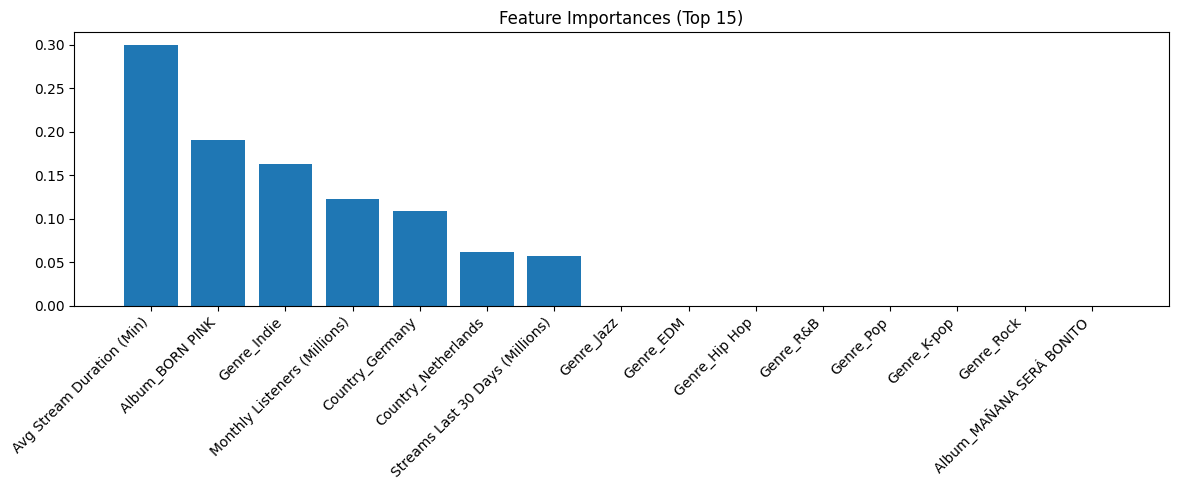

In [23]:
# Feature-Importances anzeigen
importances = reg_tree.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,5))
plt.title("Feature Importances (Top 15)")
# Zeige nur die wichtigsten 15 Features an
top_n = 15
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), [X_encoded.columns[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

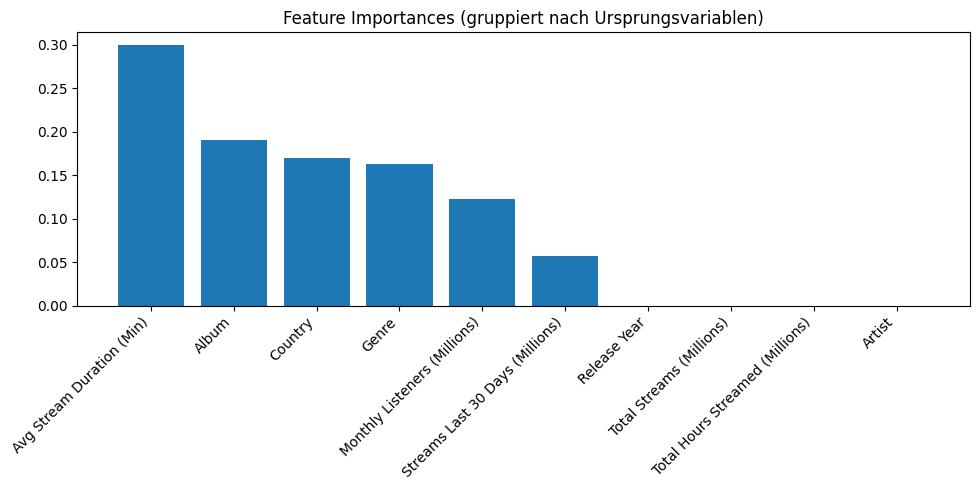

In [24]:
from collections import defaultdict

# Feature-Importances gruppiert nach Ursprungsvariablen anzeigen
importances = reg_tree.feature_importances_
feature_names = X_encoded.columns

# Ursprungsvariablen bestimmen
orig_vars = feature_cols

# Initialisiert ein Dictionary mit Listen für jede Ursprungsvariable
var_to_cols = defaultdict(list)
for col in feature_names:
    found = False
    for var in orig_vars:
        if col == var or col.startswith(var + '_'):
            var_to_cols[var].append(col)
            found = True
            break
    if not found:
        var_to_cols[col].append(col)  # falls neue Spalten auftauchen

# Importance pro Ursprungsvariable aufsummieren
summed_importances = {var: importances[[feature_names.get_loc(c) for c in cols]].sum() for var, cols in var_to_cols.items()}
# Sortieren
sorted_vars = sorted(summed_importances, key=summed_importances.get, reverse=True)

plt.figure(figsize=(10,5))
plt.title("Feature Importances (gruppiert nach Ursprungsvariablen)")
plt.bar(range(len(sorted_vars)), [summed_importances[v] for v in sorted_vars], align="center")
plt.xticks(range(len(sorted_vars)), sorted_vars, rotation=45, ha='right')
plt.tight_layout()
plt.show()